In [2]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

### Downloading data: cifar10

In [5]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

In [7]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

#### List of labels

In [8]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train')
print(classes)

['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [10]:
print(os.listdir(data_dir + '/test'))

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [13]:
airplane_files = os.listdir(data_dir + '/train/airplane')

print(len(airplane_files))
print(airplane_files[:5])

5000
['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']


In [14]:
airplane_files_test = os.listdir(data_dir + '/test/airplane')

print(len(airplane_files_test))
print(airplane_files_test[:5])

1000
['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']


In [15]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

### Convert images to tensor

In [17]:
dataset = ImageFolder(data_dir + '/train', transform=ToTensor())

In [53]:
img, label = dataset[40000]
print(img.shape)
print(label)

torch.Size([32, 32, 3])
8


In [30]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [38]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

### Show images from dataset

In [54]:
def show(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  airplane (0)


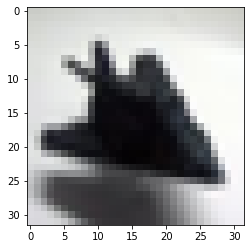

In [56]:
show(*dataset[0])

Label:  airplane (0)


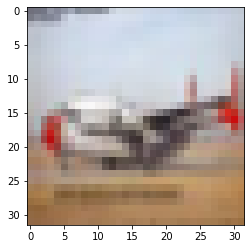

In [58]:
show(*dataset[1099])

In [59]:
torch.manual_seed(42)

### Split train and test data

In [61]:
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [62]:
from torch.utils.data.dataloader import DataLoader

### Define batch size and data loader

In [63]:
batch_size = 128

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=batch_size*2, num_workers=4, pin_memory=True)

In [65]:
from torchvision.utils import make_grid

In [68]:
def show_batch(dl):
    for imgs, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(imgs, nrow=16).permute(1, 2, 0))
        break

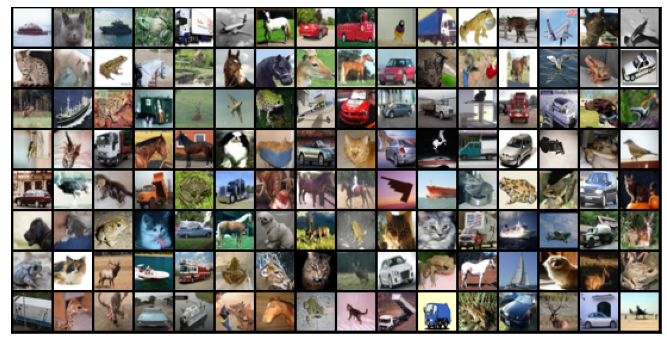

In [69]:
show_batch(train_dl)

### Define a manual kernel Multiplier

In [91]:
def apply_kernel(image, kernel):
    ri, ci = image.shape
    rk, ck = kernel.shape
    
    ro, co = ri - rk + 1, ci - ck + 1
    output = torch.zeros([ro, co])
    for i in range(ro):
        for j in range(co):
            output[i, j] = torch.sum((image[i:i+rk, j:j+ck] * kernel))
    return output

In [92]:
sample_image = torch.tensor([
    [3, 3, 2, 1, 0], 
    [0, 0, 1, 3, 1], 
    [3, 1, 2, 2, 3], 
    [2, 0, 0, 2, 2], 
    [2, 0, 0, 0, 1]
], dtype=torch.float32)

sample_kernel = torch.tensor([
    [0, 1, 2], 
    [2, 2, 0], 
    [0, 1, 2]
], dtype=torch.float32)

apply_kernel(sample_image, sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

In [93]:
import torch.nn as nn
import torch.nn.functional as F

### Define a simple model

In [95]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

### Test model without training

In [96]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([128, 3, 32, 32])


C:\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


out.shape: torch.Size([128, 8, 16, 16])


In [98]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### Define a strong CNN model

In [138]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc' : acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [139]:
class CnnModel(ImageClassificationBase):
    def __init__(self, input_ch, num_classes):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(input_ch, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes))
        
    def forward(self, inputs):
        return self.network(inputs)

In [157]:
model = CnnModel(3, 10)
model

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=10

In [127]:
for images, labels in train_dl:
    print(images.shape)
    out = model(images)
    print(out.shape)
    print(accuracy(out, labels))
    break

torch.Size([128, 3, 32, 32])
torch.Size([128, 10])
tensor(0.1406)


### Transfer data and model on GPU

In [141]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [158]:
device = torch.device('cuda')
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [143]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

### Define train function

In [148]:
def fit(epochs, lr, model, train_ld, val_ld, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_dl:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_ld)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

#### Evaluate before training

In [149]:
evaluate(model, val_dl)

{'val_loss': 1.4325495958328247, 'val_acc': 0.47927388548851013}

In [160]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.001

In [161]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.2789, val_loss: 1.1808, val_acc: 0.5673
Epoch [1], train_loss: 1.0094, val_loss: 1.0254, val_acc: 0.6278
Epoch [2], train_loss: 0.8347, val_loss: 0.8630, val_acc: 0.6964
Epoch [3], train_loss: 0.6993, val_loss: 0.8275, val_acc: 0.7116
Epoch [4], train_loss: 0.5903, val_loss: 0.7309, val_acc: 0.7462


In [162]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

### Plot accuracy and loss per epoch

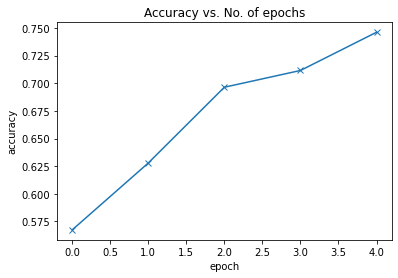

In [163]:
plot_accuracies(history)

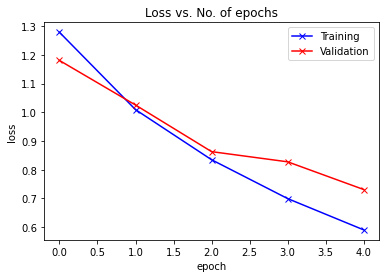

In [164]:
plot_losses(history)

In [165]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

### Test model

In [166]:
def predict_image(index, model):
    img, label = test_dataset[index]
    inp = to_device(img.unsqueeze(0), device)
    pred = model(inp)
    _, preds = torch.max(pred, dim=1)
    plt.imshow(img.permute(1, 2, 0))
    print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[preds[0].item()])

2000
Label: bird , Predicted: dog


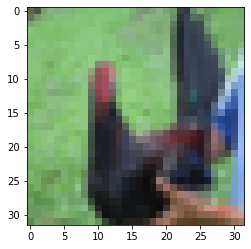

In [171]:
index = int(input())
predict_image(index, model)

In [172]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.7020328640937805, 'val_acc': 0.7562500238418579}

#### Save model

In [173]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')

In [176]:
model2 = to_device(CnnModel(3, 10), device)
model2.load_state_dict(torch.load('cifar10-cnn.pth'))

<All keys matched successfully>

In [177]:
evaluate(model2, test_loader)

{'val_loss': 0.7020328640937805, 'val_acc': 0.7562500238418579}